In [1]:
# Import libraries here.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats 
pd.set_option('display.max_columns', None)

from sklearn.linear_model import Ridge, RidgeCV

%run ../assets/regression_metrics.py

|Predictive Variable|Data type|Description|
|:---|:---|:---|
|overall_qual|Scale of 1 to 10|Rates the overall material and finish of the house|
|full_bath|int|Full bathrooms above grade|
|year_built|int|Original construction date|
|gr_liv_area_log|log of square feet|Log of above grade (ground) living area square feet|
|neighborhood_price_high|0 or 1|Is the neighborhood one standard deviation above the mean price per square feet of the total data set|
|neighborhood_price_low|0 or 1|Is the neighborhood one standard deviation below the mean price per square feet of the total data set|
|has_pool|0 or 1|Does the home have a pool|
|ms_zoning_FV|0 or 1|Is the property in a Floating Village Residential Zone|
|ms_zoning_RL|0 or 1|Is the property in a Residential Low Density Zone|
|ms_zoning_RM|0 or 1|Residential Medium Density|
|exter_cond|Ordinal 1 to 5|Evaluates the present condition of the material on the exterior|
|lot_area_log|log of square feet|Lot size|
|bed_bath_ratio|float|Ratio between number of bedrooms to number of bathrooms|
|garage_qual_cars|float|Interaction between the quality of the garage and the number of cars it fits|
|bsmt_qual|Ordinal 1 to 5|Evaluates the height of the basement|
|has_remodel|0 or 1|Was the property recently remodeled|

### 1. Read in data

In [2]:
# read in clean data sets from my pickles
train = pickle.load(open("../assets/train_clean_model.pkl", "rb"))
kaggle_test = pickle.load(open("../assets/test_clean.pkl", "rb"))

In [3]:
# remove outliers
train = train[train["gr_liv_area"] < 4000]

In [4]:
# remove outliers
train = train[train["saleprice"] < 400000]

In [5]:
# take the log of sale price for predictions
train["saleprice_log"] = np.log(train["saleprice"])

In [6]:
#starting with these variables that I selected from my correlation matrix in EDA
# features = ["overall_cond", "overall_qual", 
#             "full_bath", "bedroom_abvgr", 
#             "has_remodel", "year_built" , 
#             "gr_liv_area", "central_air", 
#             "fireplaces", "has_pool"]

# features = ["overall_qual", 
#              "full_bath", "bedroom_abvgr", 
#              "has_remodel", "year_built" , 
#              "gr_liv_area", "1st_flr_sf", 
#             "has_pool",
#             "neighborhood_price_high", "neighborhood_price_low",
#            "ms_zoning_FV", "ms_zoning_RL",
#            "ms_zoning_RM"]


features = ["overall_qual", 
             "full_bath", 
             "year_built" , 
             "gr_liv_area", 
            "neighborhood_price_high", "neighborhood_price_low",
            "has_pool",
           "ms_zoning_FV", "ms_zoning_RL",
           "ms_zoning_RM",
            "exter_cond",
           "lot_area", "bed_bath_ratio",
           "garage_qual_cars", "bsmt_qual",
           "has_remodel", "garage_type_Attchd", "garage_type_BuiltIn",
           "garage_type_Basment"]

# create a list of columns with condition 1 dummy variables
condition_1 = list(train.columns[train.columns.str.contains("condition_1_")])

# append condition 1 columns to features list
features.extend(condition_1)

In [7]:
# set up my X and y variables
X = train[features]
y = train["saleprice_log"]

### 2 . Split our data into test and train. 
- Will keep the default split at 75% train and 25% test since I have a relatively big data set.

In [8]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 500)

### 3. Scale our variables

In [9]:
# Instantiate Standard Scaler.
sc = StandardScaler()

# Fit AND transform Standard Scaler to overfit data in one step.
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [10]:
# Set up a list of Lasso alphas to check.
alphas_ridge = np.logspace(0, 2, 100)

# Cross-validate over our list of Lasso alphas.

ridge_cv = RidgeCV(
    alphas = alphas_ridge,
    cv= 5)

# Fit model using best ridge alpha!
ridge_cv.fit(Z_train, y_train)

RidgeCV(alphas=array([  1.        ,   1.04761575,   1.09749877,   1.149757  ,
         1.20450354,   1.26185688,   1.32194115,   1.38488637,
         1.45082878,   1.51991108,   1.59228279,   1.66810054,
         1.7475284 ,   1.83073828,   1.91791026,   2.009233  ,
         2.10490414,   2.20513074,   2.3101297 ,   2.42012826,
         2.53536449,   2.65608778,   2.7825594 ,   2.91505306,
         3.05385551,   3.19926714,   3.35160265,   3.51119173,
         3.67837977,   3.85352859,   4.03701726,   4....
        23.64489413,  24.77076356,  25.95024211,  27.18588243,
        28.48035868,  29.8364724 ,  31.2571585 ,  32.74549163,
        34.30469286,  35.93813664,  37.64935807,  39.44206059,
        41.320124  ,  43.28761281,  45.34878508,  47.50810162,
        49.77023564,  52.14008288,  54.62277218,  57.22367659,
        59.94842503,  62.80291442,  65.79332247,  68.92612104,
        72.20809018,  75.64633276,  79.24828984,  83.02175681,
        86.97490026,  91.11627561,  95.4548456

In [11]:
# evaluate model on train split
ridge_cv.score(Z_train, y_train)

0.9110635985559841

In [12]:
# evaluate model on test split
ridge_cv.score(Z_test, y_test)

0.8452011463606222

In [13]:
# generate predictions
y_pred = ridge_cv.predict(Z_train)

In [14]:
# calculate root mean squared error
rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(y_pred)))
print(f"rmse: {rmse}")

rmse: 19688.424441666306


### 4. Run model on Kaggle test data


In [15]:
# set up X variable
X_kaggle = kaggle_test[features]

In [16]:
# transform to standard scaler
Z_kaggle = sc.fit_transform(X_kaggle)

In [17]:
# generate predictions
y_preds = np.exp(ridge_cv.predict(Z_kaggle))

In [18]:
# create dataframe for submissions
submission = pd.DataFrame(y_preds, index=kaggle_test.index, columns=['SalePrice'])

In [19]:
# sort by index
submission.sort_index(inplace=True)

In [20]:
# write to CSV
submission.to_csv("../datasets/submissions/submission_ridge.csv")

### 5. Evaluate Model

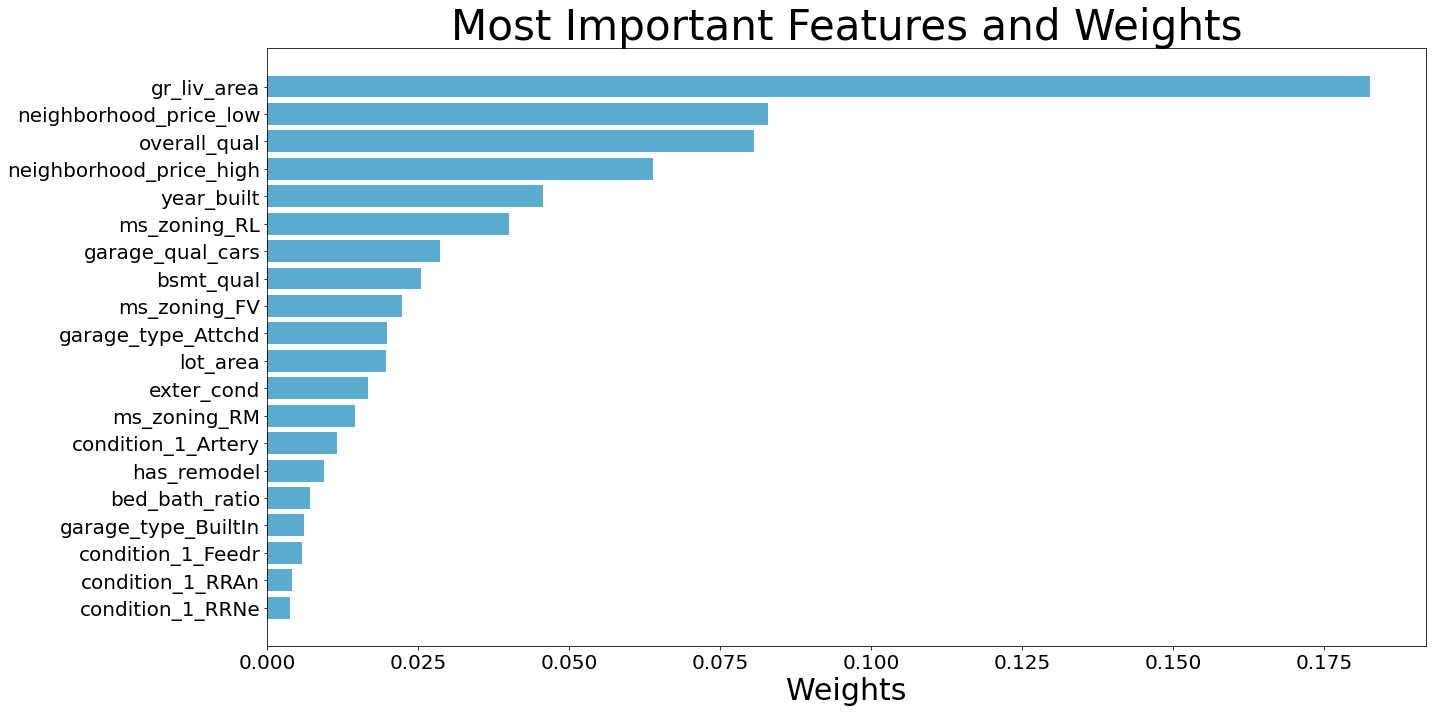

In [21]:
# This code was shared by Daniel Kim in class

# create a dataframe of our features and their coefficients
beta_df = pd.DataFrame({'Predictor Variables' : features, 'Beta':ridge_cv.coef_})

# take the absolute value of coefficients
beta_df['Absolute_Beta'] = abs(beta_df['Beta'])
beta_df = beta_df.sort_values('Absolute_Beta', ascending = False) # sort descending
beta_df = beta_df.reset_index(drop=True) # drop index row
beta_df = beta_df.set_index('Predictor Variables')
beta_df = beta_df[beta_df['Absolute_Beta'] != 0] #removes coefficients of 0
beta_df.head(10)
beta_0 = ridge_cv.intercept_
weights = beta_df['Absolute_Beta'].head(20).sort_values()
labels = weights.index

# plot in bar chart
plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = "#5caccf")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights', fontsize=42)
plt.tight_layout()
plt.savefig('../plots/beta_lasso.png')

Since my dependent variable is on a log sale, this means that a one unit increase in my predictor variables will have a percent change in the sale price. The predictor variables have been transformed into standard scaler, so a one unit increase means moving one standard deviation above the mean.

So moving one standard deviation above the mean in above ground living area square feet will have an expected 20% increase on sale price. I calculate this by taking the exponent of the beta value, and subtract by one.

### 6. Plot the predicted sale price against the actual sale price

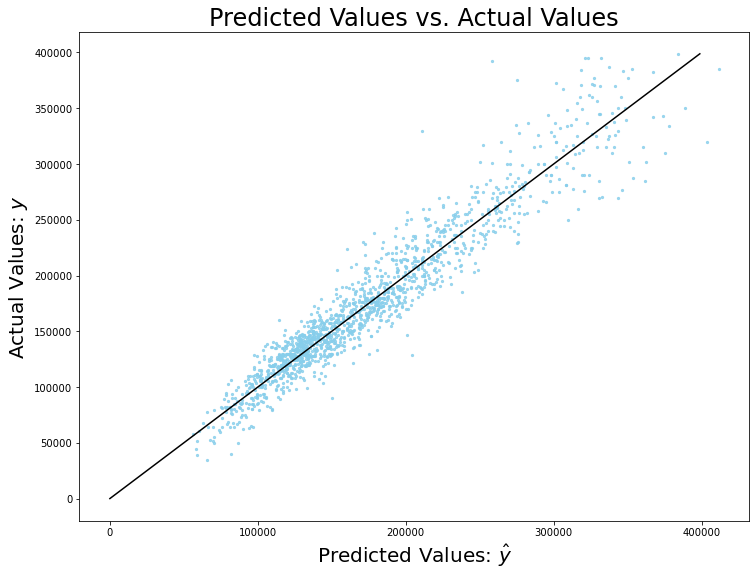

In [22]:
# Code from 3.01-lesson-linear_regression 
# Plot the model
plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(np.exp(y_pred), np.exp(y_train), s=5, color='skyblue', alpha = 0.8)

# Plot a line.
plt.plot([0, np.exp(np.max(y))],
         [0, np.exp(np.max(y))],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24)
plt.savefig('../plots/ridge_predictions.png');